# Analalyse de la distribution du vocabulaire

## Imports et dépendances

### Nettoyage avec spacy

In [37]:
import os
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from collections import Counter
import matplotlib.pyplot as plt

# Télécharger les stopwords si nécessaire
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
# Chemin vers le corpus nettoyé
path = "../../data/clean_corpus.txt"

with open(path, "r", encoding="utf-8") as f:
    full_text = f.read().strip()

print(f"Corpus chargé : {len(full_text):,} caractères ({len(full_text)/10**6:.2f} Mo)")


Corpus chargé : 18,479,659 caractères (18.48 Mo)


## Créer une une liste de stopwords

In [40]:
# Stopwords standard + personnalisés
sw = set(stopwords.words("french"))
custom_stopwords = [
    "article", "journal", "reportage", "kb", "texte", "page", "numéro",
    "fait", "faire", "avoir", "être", "dire", "ainsi", "ils", "elle",
    "cela", "cet", "cette", "leurs", "tout", "tous", "aussi", "non",
]
sw |= set(custom_stopwords)

print(f"{len(sw)} stopwords chargés.")


178 stopwords chargés.


In [41]:
print(f"{len(sw)} stopwords:\n {sorted(sw)}")

178 stopwords:
 ['ai', 'aie', 'aient', 'aies', 'ainsi', 'ait', 'article', 'as', 'au', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'aux', 'avaient', 'avais', 'avait', 'avec', 'avez', 'aviez', 'avions', 'avoir', 'avons', 'ayant', 'ayante', 'ayantes', 'ayants', 'ayez', 'ayons', 'c', 'ce', 'cela', 'ces', 'cet', 'cette', 'd', 'dans', 'de', 'des', 'dire', 'du', 'elle', 'en', 'es', 'est', 'et', 'eu', 'eue', 'eues', 'eurent', 'eus', 'eusse', 'eussent', 'eusses', 'eussiez', 'eussions', 'eut', 'eux', 'eûmes', 'eût', 'eûtes', 'faire', 'fait', 'furent', 'fus', 'fusse', 'fussent', 'fusses', 'fussiez', 'fussions', 'fut', 'fûmes', 'fût', 'fûtes', 'il', 'ils', 'j', 'je', 'journal', 'kb', 'l', 'la', 'le', 'les', 'leur', 'leurs', 'lui', 'm', 'ma', 'mais', 'me', 'mes', 'moi', 'mon', 'même', 'n', 'ne', 'non', 'nos', 'notre', 'nous', 'numéro', 'on', 'ont', 'ou', 'page', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'reportage', 's', 'sa',

## Nettoyage simple

In [42]:
def clean_text(text):
    # Supprime les métadonnées (### KB_123 ###)
    text = re.sub(r'###.*?###', ' ', text)
    # Supprime ponctuation superflue (garde apostrophes et tirets)
    text = re.sub(r'[^\w\s\'\-]', '', text)
    # Normalise espaces et minuscules
    text = re.sub(r'\s+', ' ', text).strip().lower()
    return text

full_text = clean_text(full_text)


## Tokeniser

In [43]:
tokens = wordpunct_tokenize(full_text)

# Filtrage : mots alphabétiques, longueur >2, non stopwords
tokens = [t for t in tokens if t.isalpha() and len(t) > 2 and t not in sw]

print(f"{len(tokens):,} tokens après filtrage initial.")


1,648,884 tokens après filtrage initial.


In [44]:
nlp = spacy.load("fr_core_news_lg", disable=["ner", "parser", "attribute_ruler", "tok2vec"])
nlp.max_length = len(full_text) + 1000

# Traitement par lots pour éviter les crashes mémoire
batch_size = 10000
lemmas = []

for i in range(0, len(tokens), batch_size):
    batch = tokens[i:i + batch_size]
    doc = nlp(" ".join(batch))
    lemmas.extend(token.lemma_.lower() for token in doc if token.lemma_.isalpha() and len(token.lemma_) > 2)

print(f"{len(lemmas):,} lemmes générés.")


1,645,911 lemmes générés.


In [45]:
freq = Counter(lemmas)

# Récupère les 800 mots les plus fréquents comme stopwords supplémentaires
extra_stopwords = {w for w, _ in freq.most_common(800)}

# Conservation de mots importants
important_words = {"bruxelles", "paris", "belgique", "europe"}
extra_stopwords -= important_words

# Mise à jour des stopwords
sw.update(extra_stopwords)

# Filtrage final
lemmas = [l for l in lemmas if l not in sw and len(l) > 2]

print(f"{len(lemmas):,} lemmes après filtrage dynamique.")


986,739 lemmes après filtrage dynamique.


20 mots les plus fréquents : [('bruxelles', 4615), ('belgique', 1624), ('europe', 725), ('victoire', 333), ('internationale', 333), ('charge', 333), ('mener', 333), ('tuer', 333), ('construire', 333), ('mauvais', 333), ('gare', 332), ('particulier', 331), ('goût', 331), ('britannique', 331), ('actuellement', 331), ('découvrir', 330), ('central', 330), ('village', 330), ('fixer', 330), ('rez', 329)]


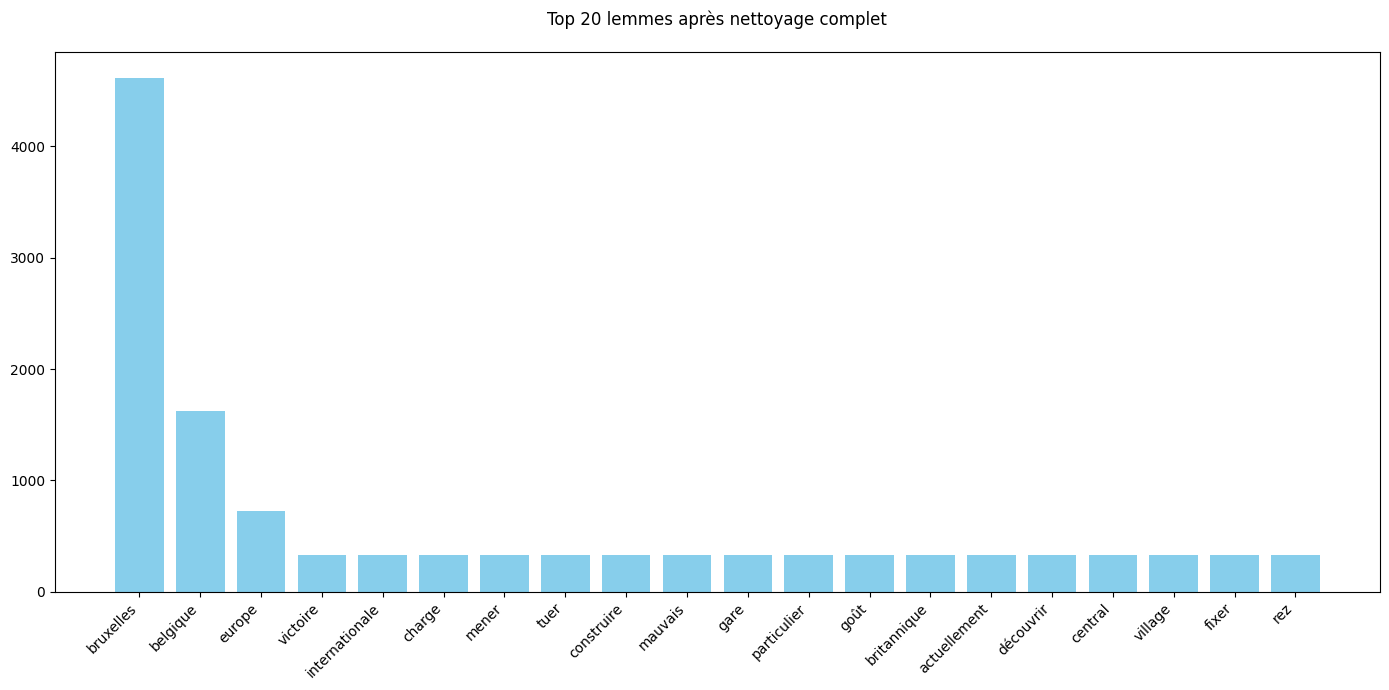

In [46]:
freq = Counter(lemmas)
most_common = freq.most_common(20)
print("20 mots les plus fréquents :", most_common)

# Plot
words, counts = zip(*most_common)
plt.figure(figsize=(14,7))
plt.bar(words, counts, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 lemmes après nettoyage complet", pad=20)
plt.tight_layout()
plt.show()


In [47]:
voc = set(lemmas)
print(f"{len(voc):,} mots uniques dans le vocabulaire.")


165,394 mots uniques dans le vocabulaire.


In [48]:
words[:10]

('bruxelles',
 'belgique',
 'europe',
 'victoire',
 'internationale',
 'charge',
 'mener',
 'tuer',
 'construire',
 'mauvais')

## Calculer la taille du vocabulaire

In [49]:
print("\n--- Vocabulaire ---")
voc = set(lemmas)
print(f"{len(voc):,} mots uniques dans le vocabulaire.")


--- Vocabulaire ---
165,394 mots uniques dans le vocabulaire.


In [50]:
#detection Hapax
hapaxes = [
    lemma for lemma, count in freq.items()
    if count == 1
    and not re.search(r'(.)\1{3,}', lemma)
    and len(lemma) < 20
    and lemma.isalpha()
]

print(f"{len(hapaxes):,} hapaxes valides (après filtrage) :")
print(hapaxes[:30])


111,479 hapaxes valides (après filtrage) :
['dordonnances', 'térielles', 'lextermination', 'daccompagnement', 'kommandantur', 'sindigne', 'denfermer', 'vonfalkenhausen', 'déclai', 'feldgendarmerie', 'lageberichte', 'dotages', 'làla', 'nadmettra', 'dexcuse', 'ilication', 'métèque', 'lesilence', 'quinvoquent', 'endra', 'analoguea', 'louvcrin', 'sadx', 'essant', 'idéalisations', 'rabahl', 'capres', 'vinqt', 'intérallié', 'eisenliower']


In [51]:
# Mots les plus longs
long_words = sorted(
    (w for w in voc if len(w) > 10 and not re.search(r'(.)\1{3,}', w) and w.isalpha()),
    key=lambda x: (-len(x), x)
)[:30]

print("30 mots les plus longs (filtrés) :")
for i, word in enumerate(long_words, 1):
    print(f"{i:2d}. {word} ({len(word)} lettres)")


30 mots les plus longs (filtrés) :
 1. jtkmuauœmjjtfjmmîjtîjanwhmmhhhatijaattsuîîjathœhaœahmœœmnœhihkjwlj (66 lettres)
 2. lîntîtinîîrtrrîrtjùîjjrîùtîvrrtrtîjjmmujunttmmtmtmmmhjtîmumi (60 lettres)
 3. riiriiririiîmririmririnriîrimttîmriririririmriimmmimttmmimmg (60 lettres)
 4. tiuuttmttmttmtttmttmmmtmnutmtutmtmttmmtmmtutmtmntut (51 lettres)
 5. mimmtmmimuimmibimmiimsmninmimmiinraihiiiniuumumii (49 lettres)
 6. miiniimnaiiimiimiiiumaiiittiibiviaiinviavmivii (46 lettres)
 7. îiutnnmmtmmtmtttîttmîtuîimmmummîmtnîmtummu (42 lettres)
 8. loulsmhstrongernkrlehmangmekqlyrogeredens (41 lettres)
 9. joccaslondelastjmicolastprogrammespêcial (40 lettres)
10. noeâusuccèsnëïsonrîîïâîtteoommouawtûdërj (40 lettres)
11. patïîicknowlesandrewprinerighardjaeckel (39 lettres)
12. stockwlmccujrenielsfnsavalasltwflersank (39 lettres)
13. mîtmtmmîttinuîiuttîîmnmmîtmtttmttîîï (36 lettres)
14. fmniiitmtfwttifrtiftwrmmnwnntfwfmm (34 lettres)
15. immédiatementcettesimplehabitudede (34 lettres)
16. wmœmmummtmtmtm